In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt
import seaborn as sns


/Users/mahdie/opt/anaconda3/envs/physioai/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### Physical activity

In [2]:
dfPA_treatment = pd.read_csv("data/4.PA_treatment.csv")
dfPA_control = pd.read_csv("data/4.PA_control.csv")
dfPA_balanced = pd.read_csv("data/5.PA_balanced.csv").drop(columns='Treatment')

print("Physical activity Treatment group:", dfPA_treatment.shape)
print("Physical activity Control group:  ", dfPA_control.shape)
print("Physical activity Balanced group: ", dfPA_balanced.shape)

Physical activity Treatment group: (7603, 9)
Physical activity Control group:   (4131, 9)
Physical activity Balanced group:  (4131, 9)


##### Create column outcome in categorical:

In [3]:
# Define the function to categorize PA_changes
def categorize_change(PA_change):
    if PA_change > 0:
        return 'Increased'
    elif PA_change < 0:
        return 'Decreased'
    else:
        return 'Unchanged'

# Apply the function to create a new column in df_PA_control_before
dfPA_treatment['PA_change_category'] = dfPA_treatment['PA_change'].apply(categorize_change)
dfPA_control['PA_change_category'] = dfPA_control['PA_change'].apply(categorize_change)
dfPA_balanced['PA_change_category'] = dfPA_balanced['PA_change'].apply(categorize_change)

##### Cochran-Armitage Trend Test 

In [4]:
# Define the function to categorize PA_changes
def categorize_change(PA_change):
    if PA_change > 0:
        return 'Increased'
    elif PA_change < 0:
        return 'Decreased'
    else:
        return 'Unchanged'

# Apply the function to create a new column
dfPA_treatment['PA_change_category'] = dfPA_treatment['PA_change'].apply(categorize_change)
dfPA_balanced['PA_change_category'] = dfPA_balanced['PA_change'].apply(categorize_change)

# Map PA_change to binary values (1 for Increased, 0 for Decreased or Unchanged)
dfPA_treatment['PA_change_binary'] = dfPA_treatment['PA_change_category'].map({'Increased': 1, 'Unchanged': 0, 'Decreased': 0})
dfPA_balanced['PA_change_binary'] = dfPA_balanced['PA_change_category'].map({'Increased': 1, 'Unchanged': 0, 'Decreased': 0})

# Combine the data
df_combined = pd.concat([dfPA_treatment, dfPA_balanced])
df_combined['Group'] = ['Treatment'] * len(dfPA_treatment) + ['Control'] * len(dfPA_balanced)

# Create a contingency table for the binary outcome
contingency_table = pd.crosstab(df_combined['Group'], df_combined['PA_change_binary'])

# Perform the Cochran-Armitage Trend Test (as a z-test for proportions)
count = contingency_table[1].values  # Number of successes (increased)
nobs = contingency_table.sum(axis=1).values  # Total observations in each group

z_stat, p_value = proportions_ztest(count, nobs)

# Display results
print(f"Cochran-Armitage Trend Test for PA_change between Treatment and Control groups")
print(f"Z-statistic: {z_stat}, p-value: {p_value}")


Cochran-Armitage Trend Test for PA_change between Treatment and Control groups
Z-statistic: -5.103503490800387, p-value: 3.334223594315953e-07


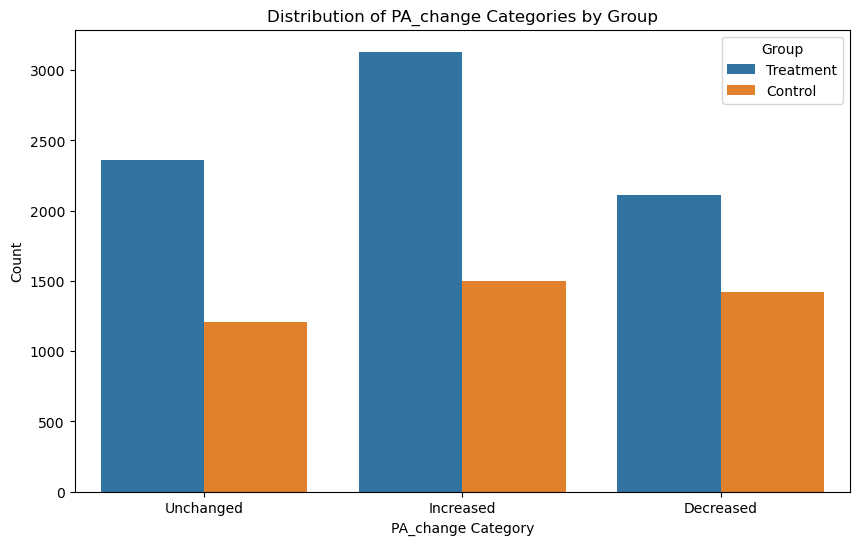

In [5]:
# Combine the data with the binary outcome
df_combined['PA_change_binary'] = df_combined['PA_change_category'].map({'Increased': 1, 'Unchanged': 0, 'Decreased': 0})

# Plot the distribution of PA_change
plt.figure(figsize=(10, 6))
sns.countplot(data=df_combined, x='PA_change_category', hue='Group')
plt.title('Distribution of PA_change Categories by Group')
plt.xlabel('PA_change Category')
plt.ylabel('Count')
plt.legend(title='Group')
plt.show()


##### Mann-Whitney U Test

In [6]:
# Map PA_change to ordinal values
pa_change_mapping = {'Decreased': -1, 'Unchanged': 0, 'Increased': 1}
dfPA_treatment['PA_change_ordinal'] = dfPA_treatment['PA_change_category'].map(pa_change_mapping)
dfPA_balanced['PA_change_ordinal'] = dfPA_balanced['PA_change_category'].map(pa_change_mapping)

# Check for NaNs in treatment and control groups
print(dfPA_treatment['PA_change_ordinal'].isna().sum())
print(dfPA_balanced['PA_change_ordinal'].isna().sum())

# Drop rows with NaNs in PA_change_ordinal if any
dfPA_treatment = dfPA_treatment.dropna(subset=['PA_change_ordinal'])
dfPA_balanced = dfPA_balanced.dropna(subset=['PA_change_ordinal'])

# Extract the ordinal values
treatment_pa_change = dfPA_treatment['PA_change_ordinal']
control_pa_change = dfPA_balanced['PA_change_ordinal']

# Perform Mann-Whitney U test
u_stat, p_value = mannwhitneyu(treatment_pa_change, control_pa_change, alternative='two-sided')

# Display results
print(f"Mann-Whitney U Test for PA_change between Treatment and Control groups")
print(f"U-statistic: {u_stat}, p-value: {p_value}")

0
0
Mann-Whitney U Test for PA_change between Treatment and Control groups
U-statistic: 16865513.5, p-value: 1.7528865910435796e-12


##### Calculate Chi2:

In [7]:
# Add a new column to identify the group
dfPA_treatment['Group'] = 'Treatment'
dfPA_balanced['Group'] = 'Control'

# Combine the dataframes
df_combined = pd.concat([dfPA_treatment, dfPA_balanced])

# Create a contingency table for PA_change_category across Treatment and Control groups
contingency_table = pd.crosstab(df_combined['PA_change_category'], df_combined['Group'])

# Perform chi-squared test
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Display results
print(f"Chi-squared Test for PA_change_category across Treatment and Control groups")
print(f"Chi2: {chi2}, p-value: {p}, Degrees of Freedom: {dof}")
print("\nExpected Frequencies:")
print(ex)
print("\nObserved Frequencies:")
print(contingency_table)


Chi-squared Test for PA_change_category across Treatment and Control groups
Chi2: 58.06458794719683, p-value: 2.4628328078404565e-13, Degrees of Freedom: 2

Expected Frequencies:
[[1244.862451   2291.137549  ]
 [1631.06553605 3001.93446395]
 [1255.07201295 2309.92798705]]

Observed Frequencies:
Group               Control  Treatment
PA_change_category                    
Decreased              1423       2113
Increased              1502       3131
Unchanged              1206       2359


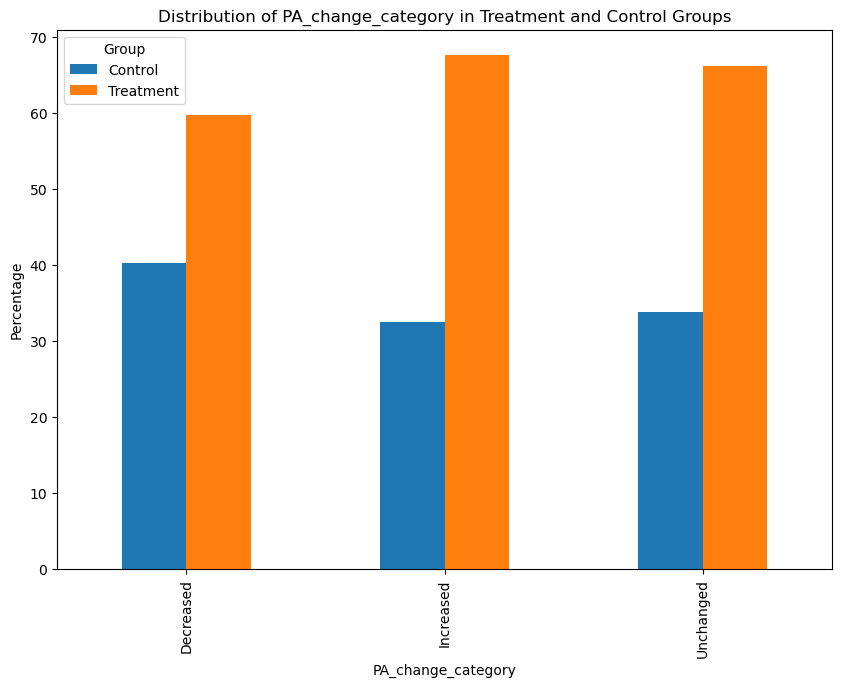

In [8]:
# Add a new column to identify the group
dfPA_treatment['Group'] = 'Treatment'
dfPA_balanced['Group'] = 'Control'

# Combine the dataframes
df_combined = pd.concat([dfPA_treatment, dfPA_balanced])

# Create a contingency table for PA_change_category across Treatment and Control groups
contingency_table = pd.crosstab(df_combined['PA_change_category'], df_combined['Group'])

# Normalize the contingency table to get percentages
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Plot the contingency table
contingency_table_percentage.plot(kind='bar', figsize=(10, 7))
plt.title('Distribution of PA_change_category in Treatment and Control Groups')
plt.xlabel('PA_change_category')
plt.ylabel('Percentage')
plt.legend(title='Group')
plt.show()


#### Quality of life

In [9]:
dfQ_treatment = pd.read_csv("data/4.QOL_treatment.csv")
dfQ_control = pd.read_csv("data/4.QOL_control.csv")
dfQ_balanced = pd.read_csv("data/5.QOL_balanced.csv")

In [10]:
# List of file paths and corresponding dataframe names
files = [
    ("data/4.QOL_treatment.csv", "dfQ_treatment"),
    ("data/4.QOL_control.csv", "dfQ_control"),
    ("data/5.QOL_balanced.csv", "dfQ_balanced"),
]

# Dictionary to store dataframes
dataframes = {}

# Loop through each file and read the csv into a dataframe, then store it in the dictionary
for file, name in files:
    dataframes[name] = pd.read_csv(file)
    print(f"{name}: {dataframes[name].shape}")

dfQ_treatment: (7603, 9)
dfQ_control: (4131, 9)
dfQ_balanced: (4131, 10)


In [11]:
# Define the function to categorize PA_changes
def QOL_categorize_significant_change(QOL_change):
    if QOL_change >= 10:
        return 'Increased 10+ points'
    elif QOL_change <= -10:
        return 'Decreased 10+ points'
    else:
        return 'Maintained'

dfQ_treatment['QOL_change_category'] = dfQ_treatment['QOL_change'].apply(QOL_categorize_significant_change)
dfQ_control['QOL_change_category'] = dfQ_control['QOL_change'].apply(QOL_categorize_significant_change)
dfQ_balanced['QOL_change_category'] = dfQ_balanced['QOL_change'].apply(QOL_categorize_significant_change)

In [12]:
dfQ_balanced

,Age,Gender,BMI,Depression,Employment_status,Baseline_Physical_Activity,Baseline_Quality_of_life,Baseline_Pain,QOL_change,Treatment,QOL_change_category
0,70.0,1.0,28.9,1.0,1.0,0,81.25,30.0,18.75,0,Increased 10+ points
1,77.0,1.0,33.6,1.0,3.0,0,37.50,50.0,12.50,0,Increased 10+ points
2,49.0,1.0,23.5,1.0,1.0,0,81.25,20.0,-6.25,0,Maintained
3,67.0,2.0,34.7,1.0,3.0,0,62.50,0.0,6.25,0,Maintained
4,56.0,2.0,23.9,1.0,1.0,0,100.00,0.0,0.00,0,Maintained
...,...,...,...,...,...,...,...,...,...,...,...
4126,59.0,2.0,30.5,1.0,1.0,9,43.75,70.0,25.00,0,Increased 10+ points
4127,52.0,1.0,30.7,1.0,1.0,9,31.25,50.0,6.25,0,Maintained
4128,52.0,1.0,30.7,1.0,1.0,9,31.25,50.0,6.25,0,Maintained
4129,52.0,1.0,30.7,1.0,1.0,9,31.25,50.0,6.25,0,Maintained


In [13]:
# Add a new column to identify the group
dfQ_treatment['Group'] = 'Treatment'
dfQ_balanced['Group'] = 'Control'

# Combine the dataframes
dfQ_combined = pd.concat([dfQ_treatment, dfQ_balanced])

# Create a contingency table for QOL_change_category across Treatment and Control groups
contingency_table = pd.crosstab(dfQ_combined['QOL_change_category'], dfQ_combined['Group'])

# Perform chi-squared test
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Display results
print(f"Chi-squared Test for QOL_change_category across Treatment and Control groups")
print(f"Chi2: {chi2}, p-value: {p}, Degrees of Freedom: {dof}")
print("\nExpected Frequencies:")
print(ex)
print("\nObserved Frequencies:")
print(contingency_table)


Chi-squared Test for QOL_change_category across Treatment and Control groups
Chi2: 1.3855907130153102, p-value: 0.5001759429748154, Degrees of Freedom: 2

Expected Frequencies:
[[ 498.15621272  916.84378728]
 [1986.99198909 3657.00801091]
 [1645.85179819 3029.14820181]]

Observed Frequencies:
Group                 Control  Treatment
QOL_change_category                     
Decreased 10+ points      502        913
Increased 10+ points     1957       3687
Maintained               1672       3003


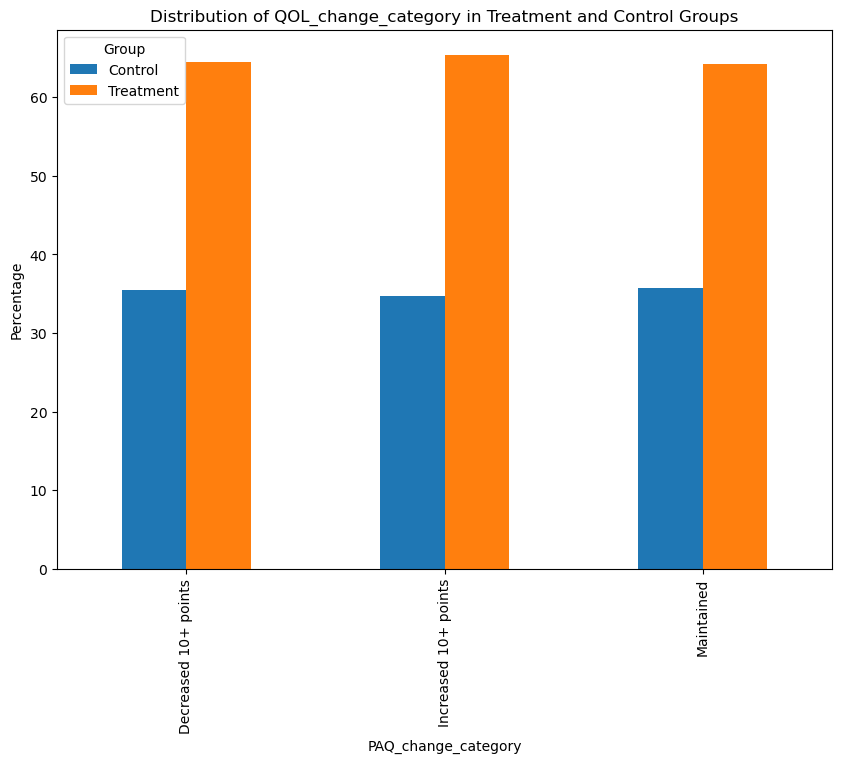

In [14]:
# Add a new column to identify the group
dfQ_treatment['Group'] = 'Treatment'
dfQ_balanced['Group'] = 'Control'

# Combine the dataframes
df_combined = pd.concat([dfQ_treatment, dfQ_balanced])

# Create a contingency table for QOL_change_category across Treatment and Control groups
contingency_table = pd.crosstab(df_combined['QOL_change_category'], df_combined['Group'])

# Normalize the contingency table to get percentages
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Plot the contingency table
contingency_table_percentage.plot(kind='bar', figsize=(10, 7))
plt.title('Distribution of QOL_change_category in Treatment and Control Groups')
plt.xlabel('PAQ_change_category')
plt.ylabel('Percentage')
plt.legend(title='Group')
plt.show()


#### Pain

In [15]:
dfpain_treatment = pd.read_csv("data/4.Pain_treatment.csv")
dfpain_control = pd.read_csv("data/4.Pain_control.csv")
dfpain_balanced = pd.read_csv("data/5.Pain_balanced.csv")

In [16]:
# List of file paths and corresponding dataframe names
files = [
    ("data/4.Pain_treatment.csv", "dfpain_treatment"),
    ("data/4.Pain_control.csv", "dfpain_control"),
    ("data/5.Pain_balanced.csv", "dfpain_balanced")
]

# Dictionary to store dataframes
dataframes = {}

# Loop through each file and read the csv into a dataframe, then store it in the dictionary
for file, name in files:
    dataframes[name] = pd.read_csv(file)
    print(f"{name}: {dataframes[name].shape}")


dfpain_treatment: (7603, 9)
dfpain_control: (4131, 9)
dfpain_balanced: (4131, 10)


In [17]:
# Define the function to categorize changes of at least 20 points
def pain_categorize_significant_change(pain_change):
    if pain_change <= -20:
        return 'Decreased 20+ points'
    elif pain_change >= 20:
        return 'Increased 20+ points'
    else:
        return 'Maintained'  # This now clearly means the pain changed but less than 20 points either way

dfpain_treatment['pain_change_category'] = dfpain_treatment['pain_change'].apply(pain_categorize_significant_change)
dfpain_control['pain_change_category'] = dfpain_control['pain_change'].apply(pain_categorize_significant_change)
dfpain_balanced['pain_change_category'] = dfpain_balanced['pain_change'].apply(pain_categorize_significant_change)


In [18]:
# Add a new column to identify the group
dfpain_treatment['Group'] = 'Treatment'
dfpain_balanced['Group'] = 'Control'

# Combine the dataframes
dfpain_combined = pd.concat([dfpain_treatment, dfpain_balanced])

# Create a contingency table for pain_change_category across Treatment and Control groups
contingency_table = pd.crosstab(dfpain_combined['pain_change_category'], dfpain_combined['Group'])

# Perform chi-squared test
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Display results
print(f"Chi-squared Test for pain_change_category across Treatment and Control groups")
print(f"Chi2: {chi2}, p-value: {p}, Degrees of Freedom: {dof}")
print("\nExpected Frequencies:")
print(ex)
print("\nObserved Frequencies:")
print(contingency_table)


Chi-squared Test for pain_change_category across Treatment and Control groups
Chi2: 381.8322429254063, p-value: 1.2195003867386102e-83, Degrees of Freedom: 2

Expected Frequencies:
[[1484.61113005 2732.38886995]
 [ 495.69183569  912.30816431]
 [2150.69703426 3958.30296574]]

Observed Frequencies:
Group                 Control  Treatment
pain_change_category                    
Decreased 20+ points     1225       2992
Increased 20+ points      811        597
Maintained               2095       4014


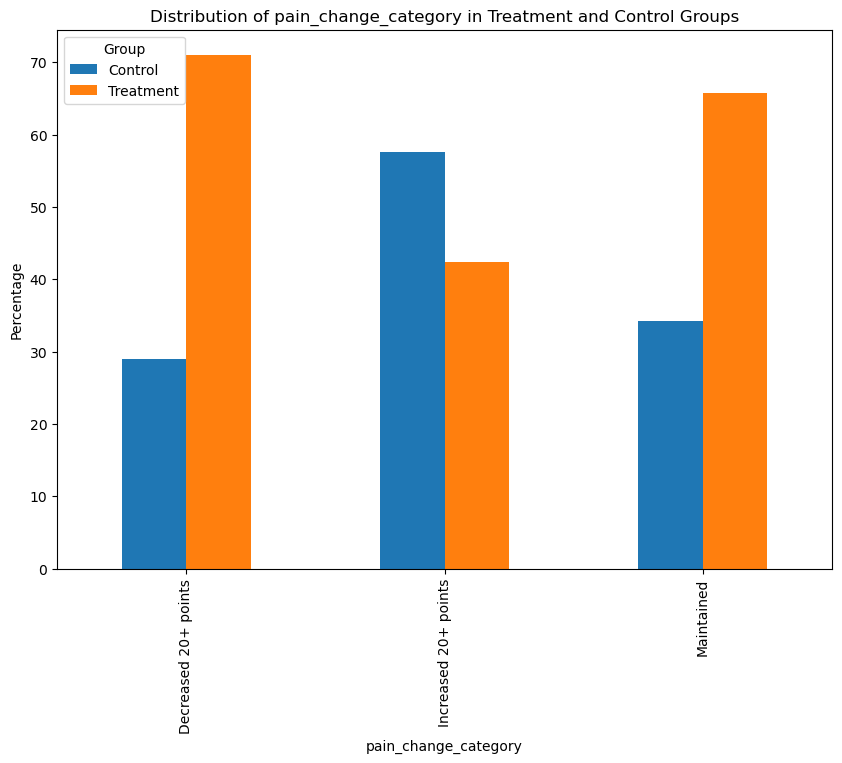

In [19]:
# Add a new column to identify the group
dfpain_treatment['Group'] = 'Treatment'
dfpain_balanced['Group'] = 'Control'

# Combine the dataframes
dfpain_combined = pd.concat([dfpain_treatment, dfpain_balanced])

# Create a contingency table for pain_change_category across Treatment and Control groups
contingency_table = pd.crosstab(dfpain_combined['pain_change_category'], dfpain_combined['Group'])

# Normalize the contingency table to get percentages
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Plot the contingency table
contingency_table_percentage.plot(kind='bar', figsize=(10, 7))
plt.title('Distribution of pain_change_category in Treatment and Control Groups')
plt.xlabel('pain_change_category')
plt.ylabel('Percentage')
plt.legend(title='Group')
plt.show()
